In [1]:
# import Biopython functions
from Bio import SeqIO

# Loading sequences

In [2]:
# load the whole transcipt
transcript = next(SeqIO.parse("ncbi/complete.fasta", "fasta"))

# load the coding sequence
coding = next(SeqIO.parse("ncbi/coding.fasta", "fasta"))

In [3]:
print("Lenth of gene:", len(transcript.seq))
print("Lenth of coding sequence:", len(coding.seq))

Lenth of gene: 169451
Lenth of coding sequence: 9429


# Get cDNA
**cDNA** - *complementary* DNA

In [4]:
transcript.seq.complement()

Seq('AACGACACACTCCGTCTTGGACGCCCCCGTCCCCGCCCGACCAAGGGACCGGTC...AGT', SingleLetterAlphabet())

In [5]:
#save -f output/cDNA str(_)

# Transcription and translation

In [6]:
mRna = coding.seq.transcribe()
mRna

Seq('AUGGCGACCCUGGAAAAGCUGAUGAAGGCCUUCGAGUCCCUCAAGUCCUUCCAG...UGA', RNAAlphabet())

In [7]:
#save -f output/mRNA str(_)

In [8]:
translation = coding.seq.translate()
translation

Seq('MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPPPPPQLPQP...TC*', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [9]:
#save -f output/translation str(_)

# Codons being used

In [10]:
seen = set()

for i in range(len(mRna) - 2):
    codon = str(mRna[i:i+3])

    if codon not in seen:
        seen.add(codon)

print(len(seen), 'codons have been seen:')
print(sorted(seen))

64 codons have been seen:
['AAA', 'AAC', 'AAG', 'AAU', 'ACA', 'ACC', 'ACG', 'ACU', 'AGA', 'AGC', 'AGG', 'AGU', 'AUA', 'AUC', 'AUG', 'AUU', 'CAA', 'CAC', 'CAG', 'CAU', 'CCA', 'CCC', 'CCG', 'CCU', 'CGA', 'CGC', 'CGG', 'CGU', 'CUA', 'CUC', 'CUG', 'CUU', 'GAA', 'GAC', 'GAG', 'GAU', 'GCA', 'GCC', 'GCG', 'GCU', 'GGA', 'GGC', 'GGG', 'GGU', 'GUA', 'GUC', 'GUG', 'GUU', 'UAA', 'UAC', 'UAG', 'UAU', 'UCA', 'UCC', 'UCG', 'UCU', 'UGA', 'UGC', 'UGG', 'UGU', 'UUA', 'UUC', 'UUG', 'UUU']


# Amino acids histogram

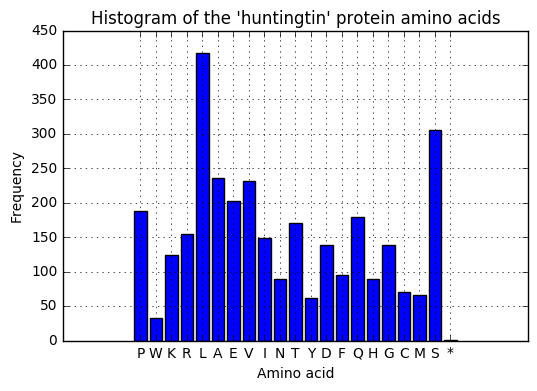

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# generate histogram
aa_hist = Counter(translation)
counts = aa_hist.values()
aas = aa_hist.keys()

# graph data
bar_x_locations = np.arange(len(counts))
plt.bar(bar_x_locations, counts, align = 'center')
plt.xticks(bar_x_locations, aas)

plt.title('Histogram of the \'huntingtin\' protein amino acids')
plt.xlabel('Amino acid')
plt.ylabel('Frequency')

plt.grid()
plt.show()

# Usage of Leucine amino acids

In [33]:
leucineCodons = ['UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG']

for codon in leucineCodons:
    print(codon, mRna.count(codon), sep=': ')

UUA: 70
UUG: 156
CUU: 168
CUC: 178
CUA: 68
CUG: 295


# Open Reading Frames (ORFs)

How many start codons are there? Where are they?

In [ ]:
print(transcript.seq.count('ATG'))

In [ ]:
seq = transcript.seq
i = 0
while seq[i:].find('ATG')>-1:
    j = seq[i:].find('ATG')
    i = i + j + 3
    print(i - 3)


This is a list of possible coding region starting points.

## Alternative strategy

Each true ORF should end with a stop codon. So we can translate the sequence using all three different reading farmes, and search for start-> stop codon sequences.

In [ ]:
f1 = transcript.seq.translate().split('*')
f2 = transcript.seq[1:].translate().split('*')
f3 = transcript.seq[2:].translate().split('*')
print(f1)


These are all candidate coding sequences ending with a stop codon. Now check if there is a start codon. Since we have now got amino acis sequences, we should search for the amino acid equivalent of 'ATG', which is 'M' (Methionine)

In [ ]:
for i,f in enumerate((f1,f2,f3)):
    print("Reading frame: "+str(i+1))
    for p in f:
        M = p.find('M')
        if M>=0:
            print((len(p)-M+1)*3)

These are the lengths of all possible open reading frames. There are many different candidates. Often the longest is the correct one, here that is the case too.

Note: here we know the 5' -> 3' direction (can you see why?), but generally both directions should be searched.

## Putting everything together

In [ ]:
# a simple ORF finder

seq = transcript.seq

# search for at least 100 amino acid length:
min_len = 100

for strand, nuc in [(+1, seq), (-1, seq.reverse_complement())]:
    for frame in range(3):
        pos = 0
        for prot in nuc[frame:].translate().split('*'):
            if len(prot) >= min_len:
                start = prot.find("M")
                print("%s...%s - fragment length: %i, strand: %i, frame: %i, pos: %i, start: %i, coding length %i, has start %s" % (prot[start:start+10], prot[-3:], (len(prot)-start+1)*3, strand, frame, pos*3, (max(0,start)+pos+frame)*3+1, (len(prot[start:])+1)*3, start>-1))
                pos = pos + len(prot)+1